## AIPI 590 - XAI | Assignment #5
### Explainable Techniques
#### Author: Tal Erez
#### Colab Notebook:
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)]()

### Introduction
This notebook demonstrates how to use LIME to generate local explanations for images. The images used come from a small version of the ImageNet library, and the pretrained model used for predictions is ResNet34. For a given label, this will output LIME's explanations for each image of that label in the dataset. 

### Install required dependencies and import packages

In [22]:
import os

# Remove Colab default sample_data if it exists
if os.path.exists("./sample_data"):
    !rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "ExplainableTechniques"

# Check if the repo already exists
if not os.path.exists("/content/" + repo_name):
    git_path = 'https://github.com/notthattal/ExplainableTechniques.git'
    !git clone "{git_path}"
else:
    print(f"{repo_name} already exists.")

# Change working directory to location of notebook
path_to_notebook = os.path.join("/content/" + repo_name)
%cd "{path_to_notebook}"
%ls

!pip install -r requirements.txt

import json
from lime import lime_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pytorch_lightning as pl
from skimage.segmentation import mark_boundaries
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import urllib.request
from urllib.error import HTTPError
import zipfile

You should consider upgrading via the '/Users/talerez/Documents/AIPI_590_XAI/ExplainableTechniques/venv/bin/python3 -m pip install --upgrade pip' command.


### Install the required dependencies and import the required packages

In [41]:
# Setting the seed
pl.seed_everything(42)

device = None

# Fetching the device that will be used throughout this notebook
if torch.backends.mps.is_available():
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.use_deterministic_algorithms(True)

    #set device to use mps
    device = torch.device("mps")
elif torch.cuda.is_available():
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    #set device to use cuda
    device = torch.device("cuda:0")
else:
    #set device to use the cpu
    device = torch.device("cpu")

print("Using device", device)

Seed set to 42


Using device mps


### Download the Dataset

In [42]:
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"

# Create paths if they don't exist yet
DATASET_PATH = "./data"

os.makedirs(DATASET_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
file_name = "TinyImageNet.zip"
file_path = os.path.join(DATASET_PATH, file_name)
if not os.path.isfile(file_path):
    file_url = base_url + file_name
    print(f"Downloading {file_url}...")
    try:
        urllib.request.urlretrieve(file_url, file_path)
    except HTTPError as e:
        print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
    if file_name.endswith(".zip"):
        print("Unzipping file...")
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(file_path.rsplit("/",1)[0])
            print("Unzip complete")

### Load the ImageNet Model

In [43]:
# Load a pre-trained ResNet-34 model with ImageNet weights
pretrained_model = models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# Set model to evaluation mode
pretrained_model.eval()

# Specify that no gradients needed for the network
for p in pretrained_model.parameters():
    p.requires_grad = False

### Load the Dataset and Label Names

In [44]:
# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

# get a list of folders in sorted order for retrieving pictures by label
folders = sorted([f for f in os.listdir(imagenet_path) if os.path.isdir(os.path.join(imagenet_path, f))])

### Get all images for a specific label

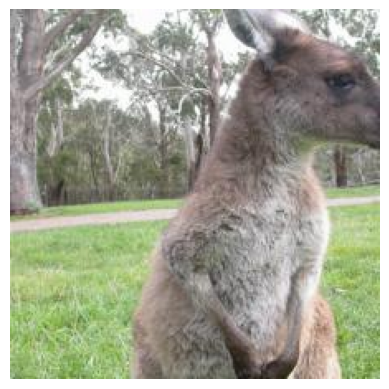

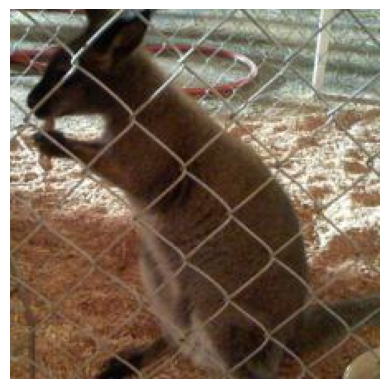

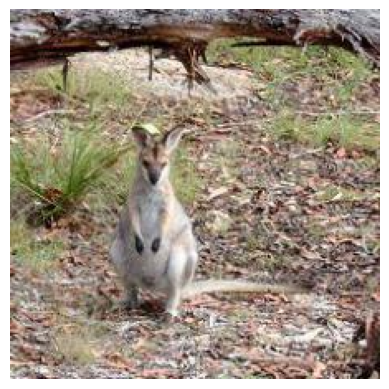

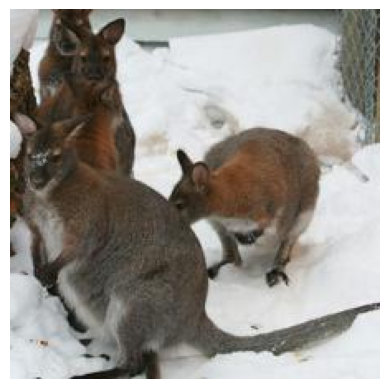

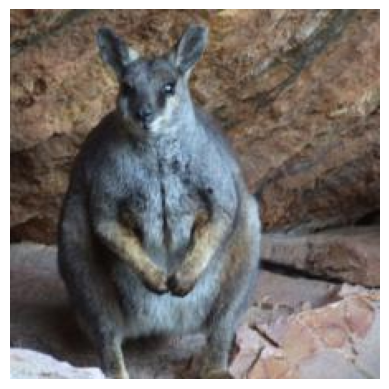

In [45]:
def get_images(label_name):
    '''
    gets a list of images in RGB format by label name from the TinyImageNet dataset

    Inputs:
        label_name (str): the label for which to retrieve the images
    
    Return:
        images (list): a list of the images retrieved
    '''
    #get the index of the label from label_list.json
    index = label_names.index(label_name)

    #get the corresponding folder of images from TinyImageNet
    folder = imagenet_path + folders[index] + '/'

    #get the images from the selected folder
    image_names = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    images = []
    for image_name in image_names:
        #open the image
        with open(os.path.relpath(folder + image_name), 'rb') as f:
            with Image.open(f) as img:
                #convert the image to RGB and add it to the output list
                images.append(img.convert('RGB'))
    
    return images

#get the images by label
images_rgb = get_images('wallaby')

#show the images
for img in images_rgb:
    plt.imshow(img)
    plt.axis("off")
    plt.show() 

### Create Transforms

In [46]:
# Set the Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# Convert the input image to PyTorch Tensor, normalize the images using the mean and standard deviation above and 
plain_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=NORM_MEAN,
                             std=NORM_STD)
    ])   

# Resize and take the center part of image to what our model expects
pil_transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

### Create a Function to Get Predictions From an Image

In [68]:
def batch_predict(image):
    '''
    Add a batch dimension to a Pytorch tensor, get predictions from the model, and return the probabilities

    Input:
        image (Pytorch Tensor): the image used for prediction
    
    Return:
        A numpy array of the computed probabilities
    '''
    # apply transformations to each image and stack them into a batch (a tensor) along a new dimension.
    batch = torch.stack(tuple(plain_transforms(i) for i in image), dim=0)

    # move the batch to the device
    batch = batch.to(device)
    
    # feed the batch to the model to get the logits
    logits = pretrained_model(batch)

    # convert logits to probabilities
    probs = F.softmax(logits, dim=1)

    # detach the computed probabilities from the computational graph, move them back to the CPU and convert them into a numpy array
    return probs.detach().cpu().numpy()

### Verify The Model is Correctly Predicting The Label

In [69]:
# get predictions for each image
for i in range(len(images_rgb)):
    # get predictions from the model
    test_pred = batch_predict([pil_transf(images_rgb[i])])

    # get the label corresponding to the highest prediction
    print("Prediction for Image: " + str(i + 1) + ": " + label_names[test_pred.squeeze().argmax()])

Prediction for Image: 1: wallaby
Prediction for Image: 2: wallaby
Prediction for Image: 3: wallaby
Prediction for Image: 4: wallaby
Prediction for Image: 5: wallaby


### Run Lime And Get The Explanations
- Generates an explanation for a single image
- resizes and crops the image
- uses batch_predict to get the prediction
- gets the top 5 predicted labels
- num_samples=1000 will have LIME generate 1000 variations of the image to see how the prediction changes 


In [81]:
# instantiate the LimeImageExplainer and explanations array
explainer = lime_image.LimeImageExplainer()
explanations = []

# get explanations for each image
for img in images_rgb:
    explanations.append(explainer.explain_instance(np.array(pil_transf(img)), 
                                            batch_predict, # classification function
                                            top_labels=5, 
                                            hide_color=0, 
                                            num_samples=1000))

100%|██████████| 1000/1000 [00:03<00:00, 268.76it/s]


### Show The Explanations
- show the images with the explanations overlayed for each image in the label

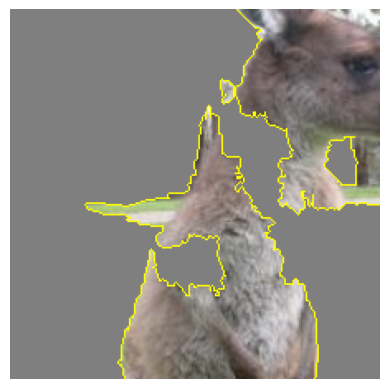

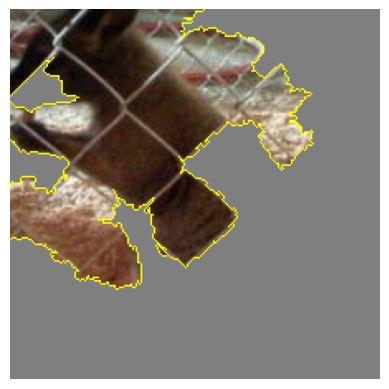

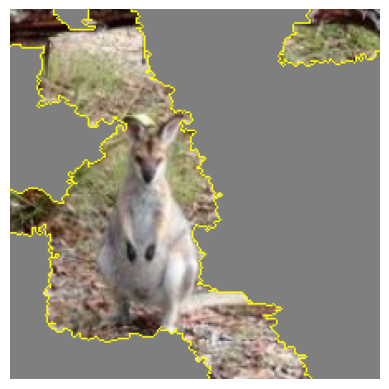

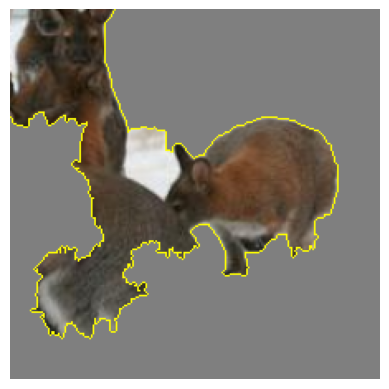

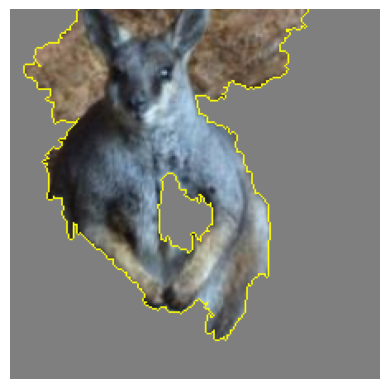

In [91]:
for explanation in explanations:
    # get the image and mask for each image
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
    
    # normalize the image to range [0, 1]
    temp = temp.astype(float) / 255.0  

    # convert mask to bool to apply changes to the unimportant part of the image
    mask = mask.astype(bool)

    # Create a gray image to replace the unimportant parts
    gray_image = np.ones_like(temp) * 0.5

    # Combine the important parts of the original image and the gray image for the unimportant parts
    temp[~mask] = gray_image[~mask] 

    # Add boundaries to the image
    img_boundry2 = mark_boundaries(temp, mask)

    # plot and show the images
    plt.imshow(img_boundry2)
    plt.axis("off")
    plt.show()

## Discussion
LIME (local interpretable model-agnostic explanations) was chosen because LIME works with image data (which is the data chosen for this project) and the explanations generated by the model are intuitive to understand. Pros to LIME in general, but not necesarily for the case of this notebook, is that it is model agnostic meaning we could switch out Resnet34 and still use this explanable method. It also works with text and tabular data along with image data. Some limitations to LIME are that (especially for higher dimensional feature spaces) there isn't a robust method of finding the optimal kernel width for the exponential smoothing kernel used in its implementation. LIME explanations can also be inconsistent, LIME can be used to hide biases and it can be easily fooled.  

## Citations:

Lippe, Phillip, & Bent, Brinnae, PhD "Tutorial 10: Adversarial attacks." Github, 2024, https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/local_explanations.ipynb

[Shah, Shital](https://github.com/sytelus) "Tutorial - images - Pytorch." Github, 2019, https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb